In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Local application imports
from smile.population import Population, PopulationList
from smile.sampling import *
from smile.regression import RegressionResultList
from smile import helper
from smile.helper import truncatednormal
from smile.global_params import *

In [3]:
# Settings
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)
np.set_printoptions(edgeitems=30, linewidth=100000)

## Experiment -1: Realistic Methodology

Purpose:  
   * Sampling similarly to what a real clinician would want

In [4]:
# Simulation definition

def get_poster_populations(slope_option, error_option, npersons=100, npops=100):
    '''
    returns a PopulationList similar to the one described in the poster
    slope_option is 1, 2, or 3
    error_option is 30/100 or 50/100
    '''
    
    # Define and set visual score function
    pop = Population(npersons, f'poster with {slope_option} and {error_option}')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 0.2
    gen_v0 = lambda shape: np.random.randint(14, 18+1, shape)
    pop.set_parameter_generator('r', gen_r, 'population')
    pop.set_parameter_generator('v0', gen_v0, 'person')

    # Define and set symptom score function
    gen_symptomscores = lambda v,a,s0: np.maximum(a*v+s0, SMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: slope_option
    gen_s0 = lambda shape: np.random.normal(6, 2, shape)
    pop.set_parameter_generator('a', gen_a, 'population')
    pop.set_parameter_generator('s0', gen_s0, 'person')

    # Define and set error functions
    #Multiplicative
    pop.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: np.random.uniform(1-error_option, 1+error_option, shape)
    pop.set_parameter_generator('C', gen_C_mul, 'day')

    # Repeat
    pops = PopulationList.full(npops, pop)
    
    # Return
    return pops

npersons=10
npops=10
slope_options = (1, 2, 3)
error_options = (0.3, 0.5)

npersons=10
npops=10

poplists = np.empty((len(slope_options), len(error_options)), dtype=object)
for i, j in np.ndindex(poplists.shape):
    poplists[i, j] = get_poster_populations(slope_options[i], error_options[j], npersons, npops)
    poplists[i, j].generate()

In [5]:
# Sampling

methodologies = [SmileMethodology(title='smile', index_day=FIRSTVISIT, milestone_ratios=[0.5], smile_scorename='symptom', sample_index=False, delay=5),
                 SequentialMethodology(title='sequential smile')]
methodologies[-1].add_method_smile(index=FIRSTVISIT, ratio=0.5, triggered_by_equal=True, scorename='symptom', delay=5, limit=(None, 'NaN'), if_reached='raise')


sampled_poplists = np.empty((len(methodologies), *poplists.shape), dtype=object)
for i, j, k in np.ndindex(sampled_poplists.shape):
    sampled_poplists[i, j, k] = methodologies[i].sample(poplists[j, k])

:: UserWarning: There is a milestone that was not reached.
:: UserWarning: There is at least one person who didn't reach his milestone


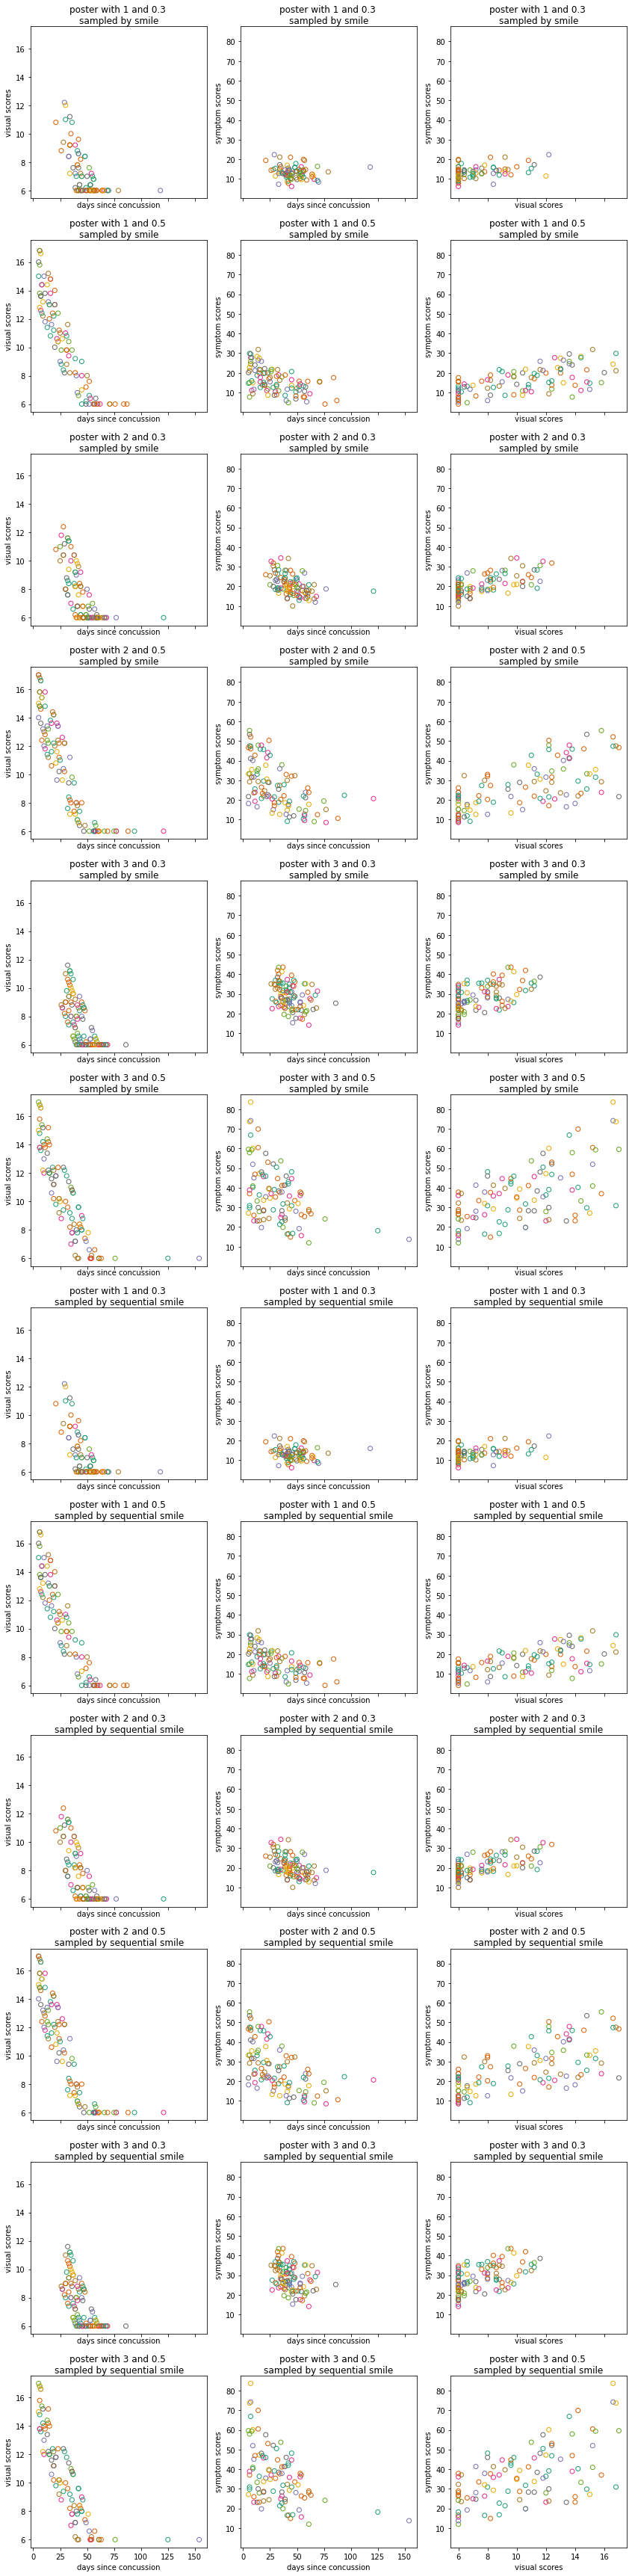

In [6]:
ncols = 3
nrows = sampled_poplists.size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*3, squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    sampled_poplists.flat[row].plot(axes[row, 0], x='day', y='visual', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flat[row].plot(axes[row, 1], x='day', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flat[row].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

In [7]:
for j, k in np.ndindex(sampled_poplists.shape[1:]):
    for l in range(10):
        same_days = np.all(sampled_poplists[0, j, k][l].days == sampled_poplists[1, j, k][l].days)
        same_visuals = np.all(sampled_poplists[0, j, k][l].scores['visual'] == sampled_poplists[1, j, k][l].scores['visual'])
        same_symptom_noerrors = np.all(sampled_poplists[0, j, k][l].scores['symptom_noerror'] == sampled_poplists[1, j, k][l].scores['symptom_noerror'])
        same_symptoms = np.all(sampled_poplists[0, j, k][l].scores['symptom'] == sampled_poplists[1, j, k][l].scores['symptom'])
        truth_vals = [same_days, same_visuals, same_symptom_noerrors, same_symptoms]
        print(f"{j, k, l}: {'all same' if np.all(truth_vals) else str(truth_vals)}")

(0, 0, 0): all same
(0, 0, 1): all same
(0, 0, 2): all same
(0, 0, 3): all same
(0, 0, 4): all same
(0, 0, 5): all same
(0, 0, 6): all same
(0, 0, 7): all same
(0, 0, 8): all same
(0, 0, 9): all same
(0, 1, 0): all same
(0, 1, 1): all same
(0, 1, 2): all same
(0, 1, 3): all same
(0, 1, 4): all same
(0, 1, 5): all same
(0, 1, 6): all same
(0, 1, 7): all same
(0, 1, 8): all same
(0, 1, 9): all same
(1, 0, 0): all same
(1, 0, 1): all same
(1, 0, 2): all same
(1, 0, 3): all same
(1, 0, 4): all same
(1, 0, 5): all same
(1, 0, 6): all same
(1, 0, 7): all same
(1, 0, 8): all same
(1, 0, 9): all same
(1, 1, 0): all same
(1, 1, 1): all same
(1, 1, 2): all same
(1, 1, 3): all same
(1, 1, 4): all same
(1, 1, 5): all same
(1, 1, 6): all same
(1, 1, 7): all same
(1, 1, 8): all same
(1, 1, 9): all same
(2, 0, 0): all same
(2, 0, 1): all same
(2, 0, 2): all same
(2, 0, 3): all same
(2, 0, 4): all same
(2, 0, 5): all same
(2, 0, 6): all same
(2, 0, 7): all same
(2, 0, 8): all same
(2, 0, 9): all same


## Experiment 0: Recreating the poster

Purpose:  
   * Recreate the data from the previous experiments summarized in the poster, to weed out coding errors or simulation/methodology discrepencies  
   
Hypothesis:  
   * Bias will be the same as the poster.  
   
Reasoning:  
   * Based on the same ideas  

In [8]:
# Simulation definition

def get_poster_populations(slope_option, error_option, npersons=100, npops=100):
    '''
    returns a PopulationList similar to the one described in the poster
    slope_option is 1, 2, or 3
    error_option is 30/100 or 50/100
    '''
    
    # Define and set visual score function
    pop = Population(npersons, f'poster with {slope_option} and {error_option}')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 0.2
    gen_v0 = lambda shape: np.random.randint(14, 18+1, shape)
    pop.set_parameter_generator('r', gen_r, 'population')
    pop.set_parameter_generator('v0', gen_v0, 'person')

    # Define and set symptom score function
    gen_symptomscores = lambda v,a,s0: np.maximum(a*v+s0, SMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: slope_option
    gen_s0 = lambda shape: np.random.normal(6, 2, shape)
    pop.set_parameter_generator('a', gen_a, 'population')
    pop.set_parameter_generator('s0', gen_s0, 'person')

    # Define and set error functions
    #Multiplicative
    pop.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: np.random.uniform(1-error_option, 1+error_option, shape)
    pop.set_parameter_generator('C', gen_C_mul, 'day')

    # Repeat
    pops = PopulationList.full(npops, pop)
    
    # Return
    return pops

npersons=10
npops=10
slope_options = (1, 2, 3)
error_options = (0.3, 0.5)

poplists = np.empty((len(slope_options), len(error_options)), dtype=object)
for i, j in np.ndindex(poplists.shape):
    poplists[i, j] = get_poster_populations(slope_options[i], error_options[j], npersons, npops)
    poplists[i, j].generate()

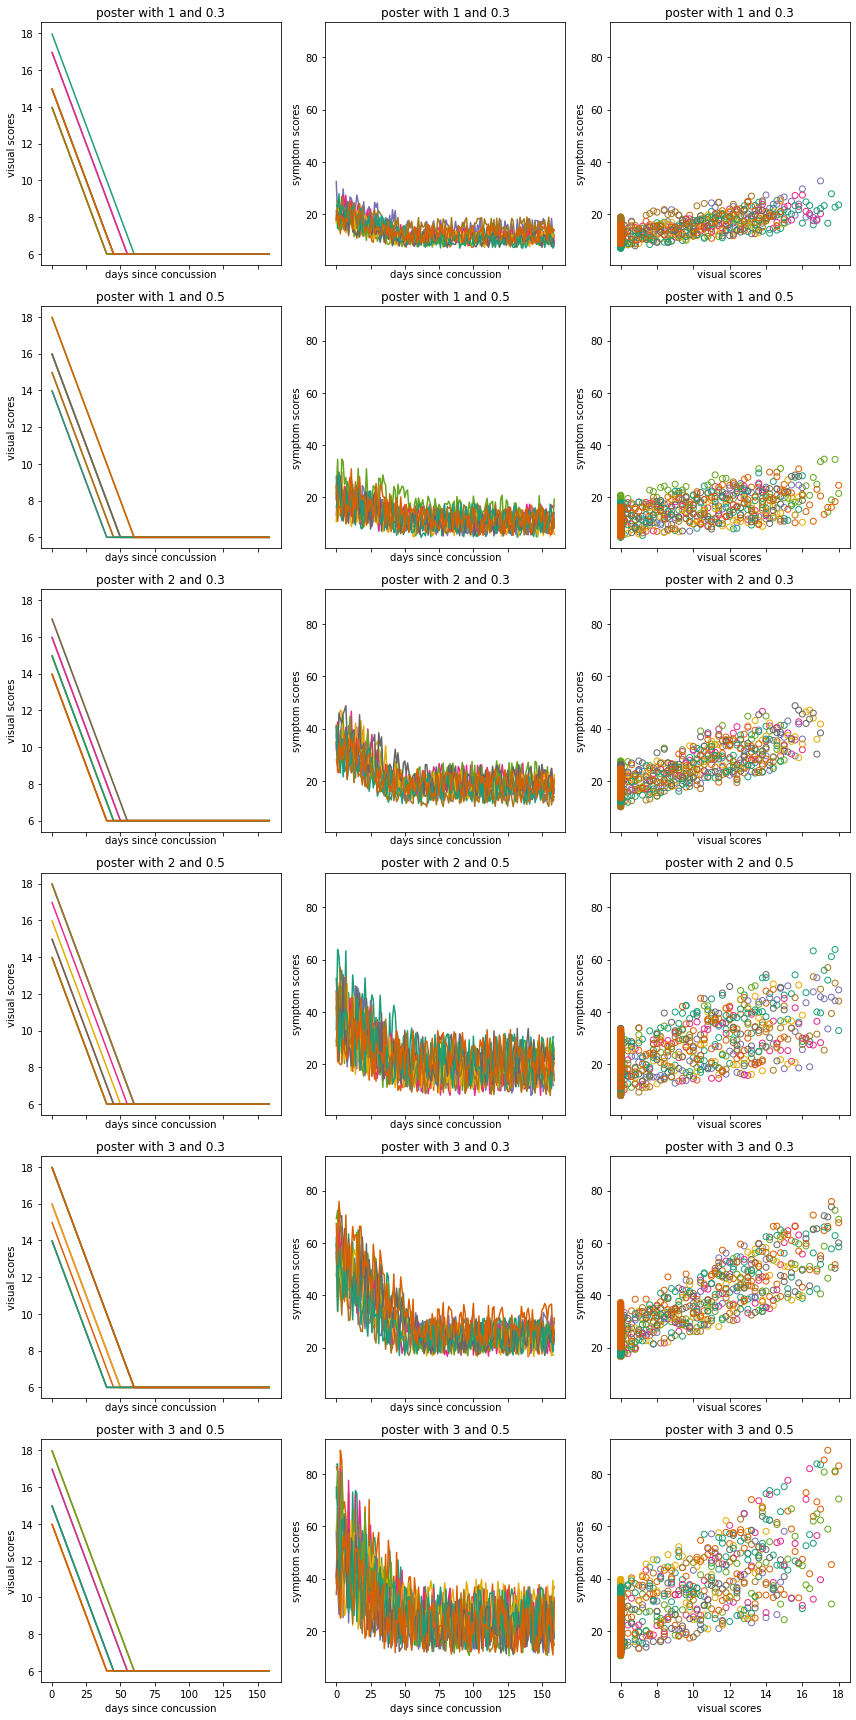

In [9]:
ncols = 3
nrows = poplists.size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*3, squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    poplists.flatten()[row][0].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

In [10]:
# Sampling

methodologies = [TraditionalMethodology('trad short', [7, 14, 28]), 
                 TraditionalMethodology('trad long', [7, 14, 90]), 
                 SmileMethodology('smile symptom', index_day=lambda shape: np.random.randint(7, 60+1, shape), 
                                  delay=lambda shape: np.random.randint(1, 7+1), milestone_ratios=[0.7, 0.4], smile_scorename='symptom'), 
                 SmileMethodology('smile visual', index_day=lambda shape: np.random.randint(7, 60+1, shape), 
                                  delay=lambda shape: np.random.randint(1, 7+1, shape), milestone_ratios=[0.7, 0.4], smile_scorename='visual')]

#filter_args = {'firstday': 7, 'lastday': 60+90} #filters out everyone

sampled_poplists = np.empty((len(methodologies), *poplists.shape), dtype=object)
for i, j, k in np.ndindex(sampled_poplists.shape):
    sampled_poplists[i, j, k] = methodologies[i].sample(poplists[j, k])

In [11]:
import numpy.ma as ma
for i, j, k in np.ndindex(sampled_poplists.shape):
    dayslist = sampled_poplists[i, j, k].days
    for l in range(len(dayslist)):
        if np.any(ma.getmask(dayslist[l])):
            print(i, j, k, l)

2 0 0 0
2 0 0 1
2 0 0 2
2 0 0 3
2 0 0 4
2 0 0 5
2 0 0 6
2 0 0 7
2 0 0 8
2 0 0 9
2 0 1 0
2 0 1 1
2 0 1 2
2 0 1 3
2 0 1 4
2 0 1 5
2 0 1 6
2 0 1 7
2 0 1 8
2 0 1 9
2 1 0 0
2 1 0 1
2 1 0 2
2 1 0 3
2 1 0 4
2 1 0 5
2 1 0 6
2 1 0 7
2 1 0 8
2 1 0 9
2 1 1 0
2 1 1 1
2 1 1 2
2 1 1 3
2 1 1 4
2 1 1 5
2 1 1 6
2 1 1 7
2 1 1 8
2 1 1 9
2 2 0 0
2 2 0 1
2 2 0 2
2 2 0 3
2 2 0 4
2 2 0 5
2 2 0 6
2 2 0 7
2 2 0 8
2 2 0 9
2 2 1 0
2 2 1 1
2 2 1 2
2 2 1 3
2 2 1 4
2 2 1 5
2 2 1 6
2 2 1 7
2 2 1 8
2 2 1 9


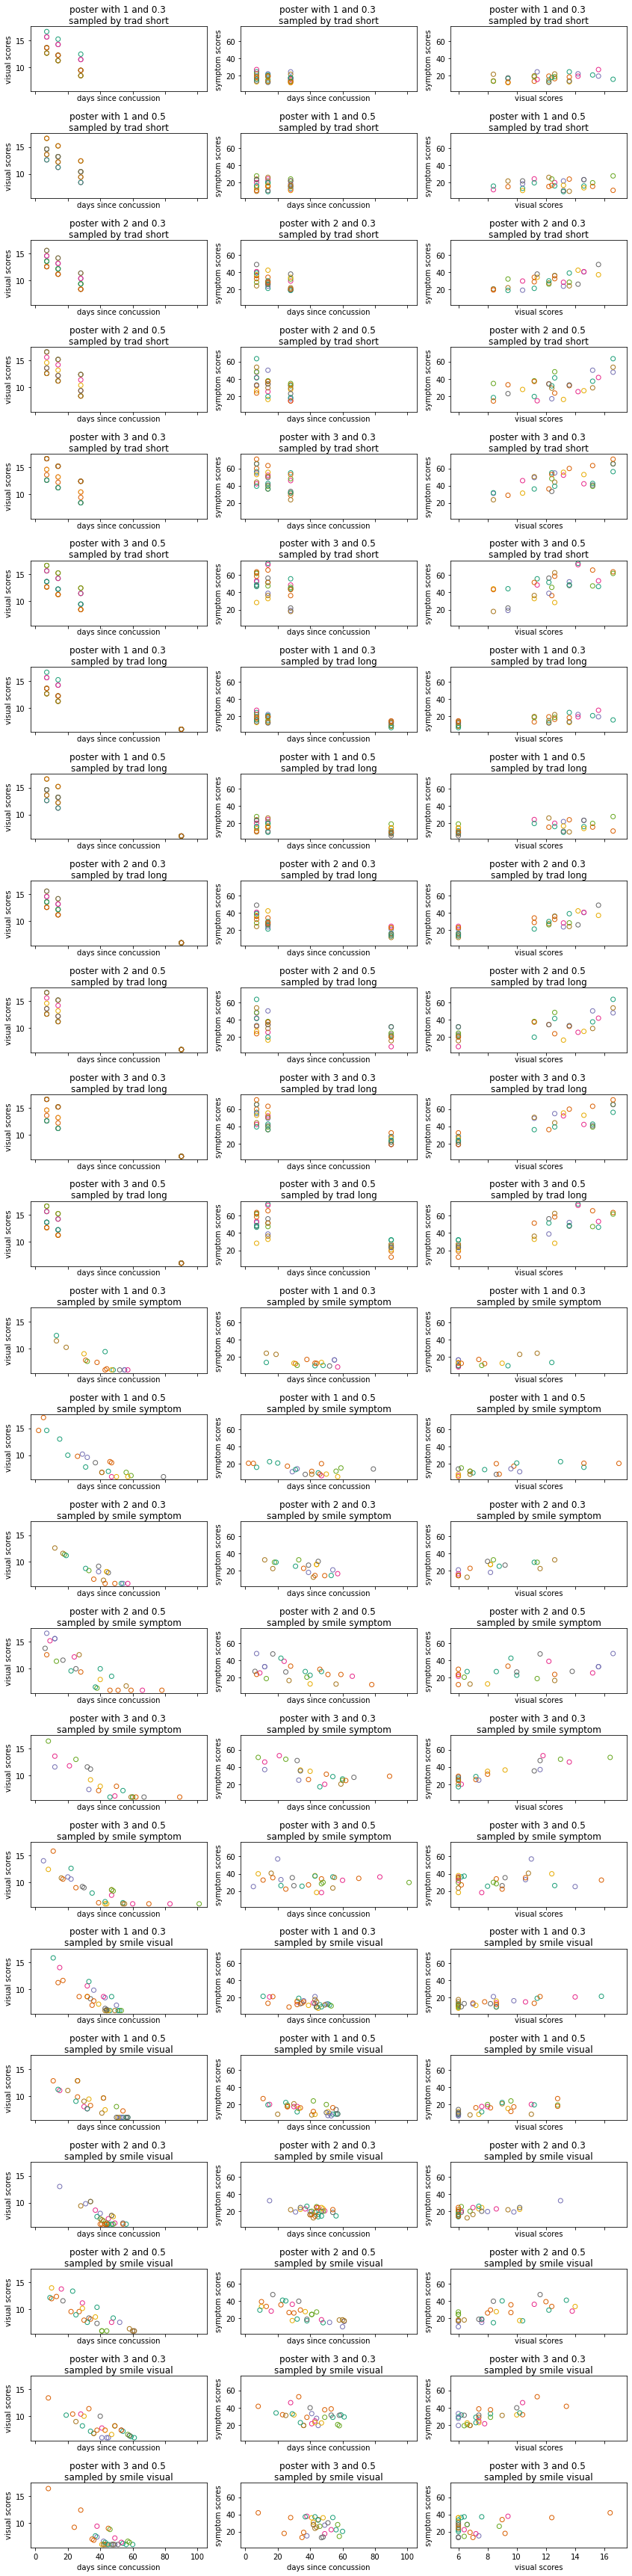

In [12]:
ncols = 3
nrows = sampled_poplists.size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*3, squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=None

for row in range(nrows):
    sampled_poplists.flatten()[row][0].plot(axes[row, 0], x='day', y='visual', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flatten()[row][0].plot(axes[row, 1], x='day', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    sampled_poplists.flatten()[row][0].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

In [13]:
# Regressions

regresults = np.empty_like(sampled_poplists)
for i, j, k in np.ndindex(regresults.shape):
    try:
        regresults[i, j, k] = sampled_poplists[i, j, k].regress_mixed(random_effect='intercept')
    except np.linalg.LinAlgError:
        regresults[i, j, k] = RegressionResultList([], 'LinAlgError')

C:\tools\Anaconda3\envs\smile\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\tools\Anaconda3\envs\smile\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\tools\Anaconda3\envs\smile\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\tools\Anaconda3\envs\smile\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2114: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\tools\Anaconda3\envs\smile\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\

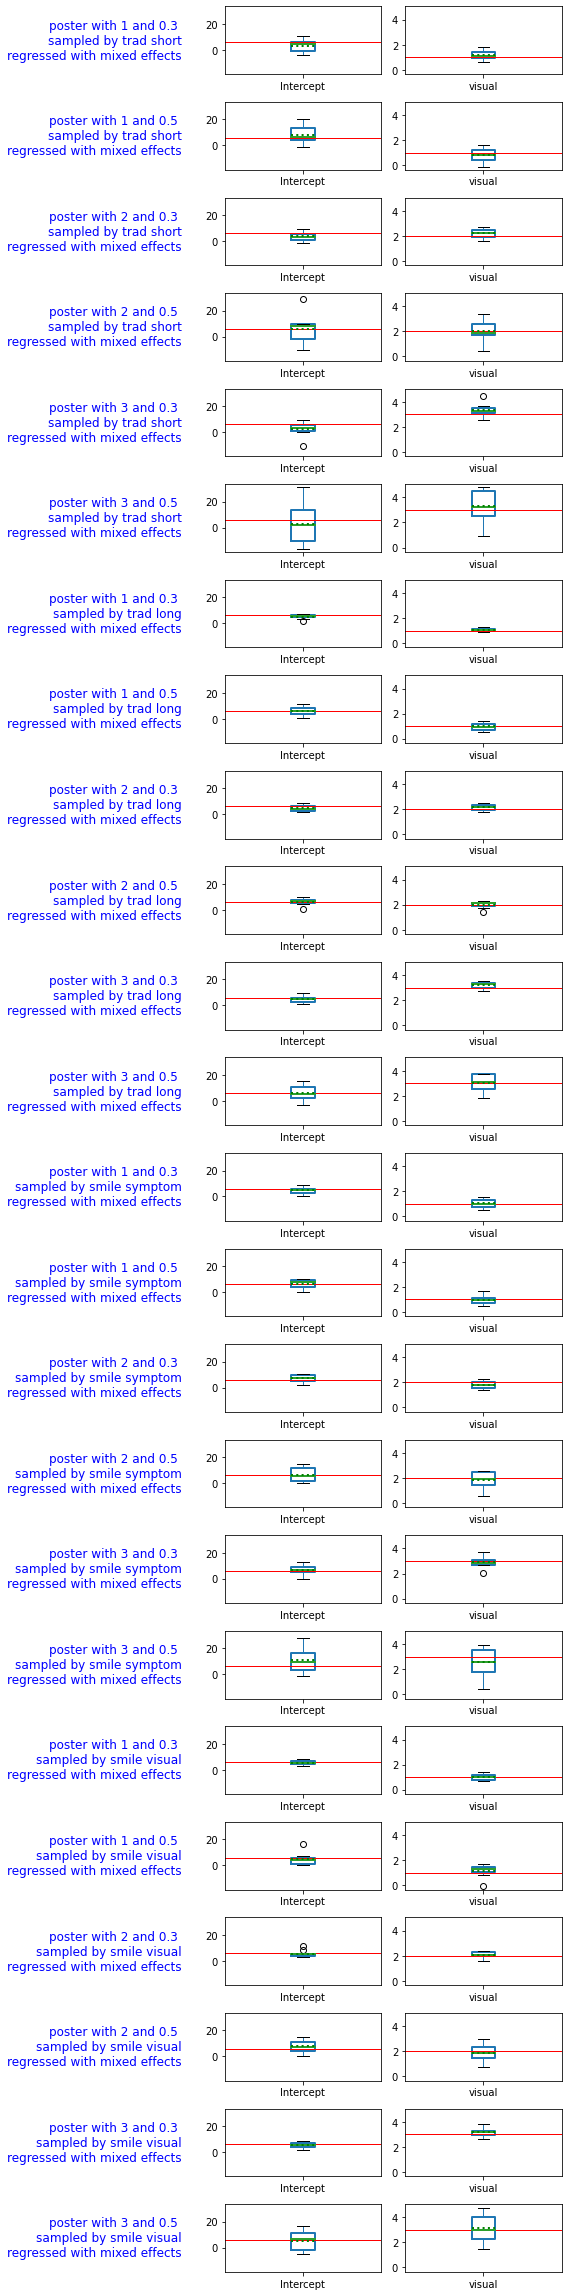

In [14]:
ncols = 2 #number of parameters
nrows = sampled_poplists.size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(0.5*nrows/ncols)*2, sharey='col', squeeze=False)

for row in range(nrows):
    meth_idx, slope_idx, err_idx = np.unravel_index(row, sampled_poplists.shape) #convert flat index to multi-dimensional index
    slope_truth = slope_options[slope_idx]
    intercept_truth = 6
    regresults[meth_idx, slope_idx, err_idx].plot_box(axes[row], ground_truths=[intercept_truth, slope_truth])
    

#Fixes bug where tick labels won't show on right axes when sharey='col'
for a in axes.flatten():
    a.tick_params(
        axis='y',
        which='both',
        left=True,
        labelleft=True)
        
plt.tight_layout()
plt.show()
#dotted green line is the mean, solid green line is the median

## Experiment 1: Baselines (Not done yet)

Purpose:  
  * Evaluate the bias in an idealized, full-information setting. Evaluate the difference between different regression models in the absence of random effects in the population.  
  
Hypothesis:  
  * There will be no bias in noerror or multiplicative error. There will be a small bias towards a slower (lower) slope in additive error. Both regressions will give the same results. Both models will give identical results.  
  
Reasoning:  
  * The relationship is linear, no persons are discarded from the population, each person will have at least two points to describe their straight line. Multiplicative error will cancel out. However, for additive errors, the enduring error when the visual score is recovered will lead to more observations at (VMIN, +s) without equivalents at (VMIN, -s) to balance them out since the symptoms have a lower bound (see thick vertical line on the left of the graph of visual vs symptom).

In [15]:
# Simulation definition

def get_baseline_populations(npersons=100, npops=100):
    '''returns a PopulationList with no errors, a PopulationList with additive errors, and a PopulationList with multiplicative errors'''
    
    # Define and set visual score function
    pop_beforeerror = Population(npersons, 'linear')
    gen_visualscores = lambda t,r,v0: np.maximum(-r*t+v0, VMIN)
    pop_beforeerror.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: truncatednormal(1/15, 31/15, 1, shape)
    gen_v0 = lambda shape: truncatednormal(14, 18, 1, shape)
    pop_beforeerror.set_parameter_generator('r', gen_r, 'person')
    pop_beforeerror.set_parameter_generator('v0', gen_v0, 'person')

    # Define and set symptom score function
    gen_symptomscores = lambda v,a: a*(v-VMIN)
    pop_beforeerror.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: 1.5
    pop_beforeerror.set_parameter_generator('a', gen_a, 'population')

    # Define and set error functions
    #None
    pop_noerror = pop_beforeerror.copy(addtitle='no error')
    pop_noerror.set_score_generator('symptom', lambda s: s)
    #Multiplicative
    pop_mulerror = pop_beforeerror.copy(addtitle='multiplicative error')
    pop_mulerror.set_score_generator('symptom', lambda s,C: s*C)
    gen_C_mul = lambda shape: truncatednormal(0.5, 1.5, 2, shape)
    pop_mulerror.set_parameter_generator('C', gen_C_mul, 'day')
    #Additive
    pop_adderror = pop_beforeerror.copy(addtitle='additive error')
    pop_adderror.set_score_generator('symptom', lambda s,C: np.maximum(s+C, SMIN))
    gen_C_add = lambda shape: truncatednormal(-5, 5, 2, shape)
    pop_adderror.set_parameter_generator('C', gen_C_add, 'day')

    # Repeat
    pops_noerror = PopulationList.full(npops, pop_noerror, title='linear no error')
    pops_mulerror = PopulationList.full(npops, pop_mulerror, title='linear multiplicative error')
    pops_adderror = PopulationList.full(npops, pop_adderror, title='linear additive error')
    
    # Return
    return pops_noerror, pops_mulerror, pops_adderror

npersons=10
npops=10

poplists = np.empty((3,), dtype=object)
poplists[:] = get_baseline_populations(10, 10)
for poplist in poplists:
    poplist.generate()

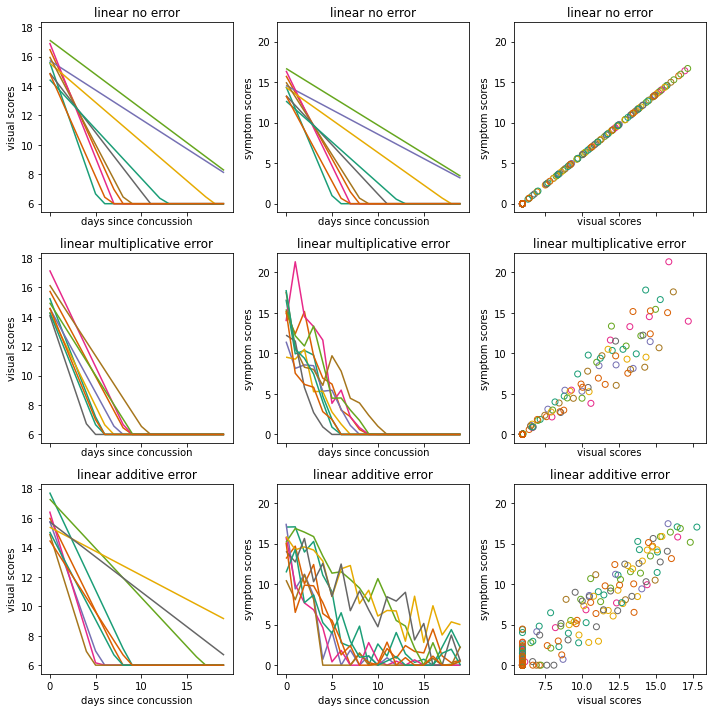

In [16]:
ncols = 3
nrows = poplists.size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2.5, squeeze=False, sharex='col', sharey='col')
npersons=None
ndays=20

for row in range(nrows):
    poplists.flatten()[row][0].plot(axes[row, 0], x='day', y='visual', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 1], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    poplists.flatten()[row][0].plot(axes[row, 2], x='visual', y='symptom', viztype='points', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

In [17]:
# Regressions

regressionresults_linear = []
regressionresults_mixed = []
for populationlist in populationlists:
    regressionresults_linear.append(populationlist.regress_linear())
    regressionresults_mixed.append(populationlist.regress_mixed())

NameError: name 'populationlists' is not defined

In [ ]:
# Plotting

ncols = 2 #number of parameters, TODO
nrows = len(list_of_results)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(0.5*nrows/ncols)*2, sharey='col', squeeze=False)

for row in range(nrows):
    slope_truth = 1
    intercept_truth = slope_truth * -smile.global_params.VMIN
    list_of_results[row].plot_box(axes[row], ground_truths=[intercept_truth, slope_truth])
        
plt.tight_layout()
plt.show()
#dotted green line is the mean, solid green line is the median